In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon
from skimage.draw import ellipse_perimeter
import os


c:\Users\Oriol\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Oriol\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Oriol\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
def extract_dicom_metadata(folder_path):
    """
    Extracts pixel spacing and slice thickness from the first DICOM file in the folder.

    Parameters:
    - folder_path: Path to the folder containing DICOM images.
    
    Returns:
    - A list of pixel spacing and an integer for slice thickness for each DICOM file found.
    """

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.dcm'):
            dicom_path = os.path.join(folder_path, file_name)
            
            try:
                # Read the DICOM file
                dicom_file = pydicom.dcmread(dicom_path)
                
                # Extract Pixel Spacing
                if 'PixelSpacing' in dicom_file:
                    pixel_spacing = dicom_file.PixelSpacing
                    pixel_spacing = list(pixel_spacing)
                else:
                    # Handle missing PixelSpacing (default to 1mm per pixel if unknown)
                    pixel_spacing = [1, 1]

                # Extract Slice Thickness
                if 'SliceThickness' in dicom_file:
                    slice_thickness = dicom_file.SliceThickness
                else:
                    slice_thickness = 1  # Default if SliceThickness is missing

                image = dicom_file.pixel_array
                image_shape = image.shape
                image_origin_mm = dicom_file.ImagePositionPatient[:2]

            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    
    return pixel_spacing, slice_thickness, image_shape, image_origin_mm



In [3]:
def load_ct_images_from_folder(folder_path):
    """
    Load all CT slices from a folder containing DICOM files.
    
    folder_path: Path to the folder containing DICOM files for a CT scan.
    
    Returns:
    - 3D numpy array of CT slices
    """
    # Load all DICOM files in the folder
    dicom_files = [pydicom.dcmread(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.dcm')]
    
    # Sort slices by InstanceNumber or another DICOM tag that reflects slice order
    dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Stack the pixel arrays into a 3D numpy array
    ct_images = np.stack([ds.pixel_array for ds in dicom_files], axis=0)

    # Extract slice thickness for each slice
    z_coordinates = [float(ds.ImagePositionPatient[2]) for ds in dicom_files]
    
    return ct_images, z_coordinates


In [4]:
# Now we want to create masks for the immobilizers, the couch and the body and implement it to the images. In the dicom files there should be a document called "RS..." 
# containing the info. 
def extract_structures(rs_file_path, keywords):
    """
    Extracts contours of specified structures from a DICOM RS (structure set) file.
    """
    # Read the RS file
    rs_dicom = pydicom.dcmread(rs_file_path)
    structure_contours = {}

    # Loop through all structures in ROIContourSequence
    for i, roi in enumerate(rs_dicom.StructureSetROISequence):
        # Check if the structure name contains any of the keywords
        roi_name = roi.ROIName.lower()
        if any(keyword in roi_name for keyword in keywords):
            print(f"Structure '{roi.ROIName}' found!")
            
            # Initialize an empty list to hold contours for this structure
            contours = []
            
            # Check if ContourSequence is present in the current ROIContour
            if hasattr(rs_dicom.ROIContourSequence[i], 'ContourSequence'):
                # Extract the contour data for each contour in ContourSequence
                for contour_seq in rs_dicom.ROIContourSequence[i].ContourSequence:
                    contour_data = contour_seq.ContourData
                    contours.append(np.array(contour_data).reshape(-1, 3))  # Reshape to (x, y, z) points
                structure_contours[roi.ROIName] = contours
            else:
                print(f"Warning: Structure '{roi.ROIName}' does not contain ContourSequence.")
                
    return structure_contours

In [5]:
def compute_centroids(structure_contours):
    """
    Compute the centroids for the extracted structures.
    
    Parameters:
    - structure_contours: Dictionary containing structure names as keys and 3D arrays of contour points (x, y, z).
    
    Returns:
    - centroids: A dictionary containing the centroids (x, y, z) for each structure.
    """
    centroids = {}
    
    for structure_name, contours in structure_contours.items():
        # Flatten all contour points into a single array
        all_points = np.concatenate(contours, axis=0)
        # Compute the centroid (mean of x, y, z points)
        centroid = np.mean(all_points, axis=0)
        centroids[structure_name] = centroid
    
    return centroids

In [6]:
#This will be used for the isocenter 
def get_image_center_in_mm(image_shape, pixel_spacing, image_origin_mm):
    """
    Compute the center of the image in patient coordinates (mm).
    
    Parameters:
    - image_shape: Shape of the image (rows, columns).
    - pixel_spacing: Pixel spacing in mm [row_spacing, col_spacing].
    - image_origin_mm: Origin of the image in mm (from DICOM header).
    
    Returns:
    - center_mm: The (X, Y) coordinates of the image center in mm.
    """
    # Compute image center in pixel coordinates
    center_px = (image_shape[0] // 2, image_shape[1] // 2)  # (row, column)
    
    # Convert to millimeter coordinates
    center_mm = [
        image_origin_mm[0] + center_px[1] * pixel_spacing[1],  # X in mm
        image_origin_mm[1] + center_px[0] * pixel_spacing[0]   # Y in mm
    ]
    
    return center_mm



In [7]:
def contours_to_mask_2d(image_shape, structure_contours, pixel_spacing, slice_z_mm, image_origin_mm):
    """
    Converts 3D contours in mm to a 2D binary mask for a specific CT slice with optional couch offset.
    
    Parameters:
    - image_shape: Shape of the output mask (same as the DICOM image).
    - structure_contours: Dictionary containing structure names as keys and 3D arrays of contour points (x, y, z).
    - pixel_spacing: List of [row_spacing, column_spacing] in mm.
    - image_origin_mm: (x, y) origin in mm to align contours with the image.
    - slice_z_mm: The Z-coordinate of the current slice in mm.
    - couch_offset_y_mm: Y-axis offset for couch positioning (in mm).

    Returns:
    - A binary mask where the area within the contours is 1 (inside) and 0 (outside).
    """
    
    mask = np.zeros(image_shape, dtype=np.uint8)
    contours_detected = False  # Flag to track if any contour was plotted

    for structure_name, z_contours_list in structure_contours.items():
        for points_3d in z_contours_list:
            # Filter contours that match the current Z-level slice
            contours_2d = [[x, y] for x, y, z in points_3d if np.isclose(z, slice_z_mm, atol=1e-1)]
            
            if len(contours_2d) > 0:
                contours_detected = True
                print(f"Contours detected for {structure_name} at Z = {slice_z_mm} mm")

                # Convert contour points from mm to pixels, aligned to image origin
                contour_px = [
                    ((point[1] - image_origin_mm[1]) / pixel_spacing[0], 
                     (point[0] - image_origin_mm[0]) / pixel_spacing[1]) 
                    for point in contours_2d
                ]
                contour_px = np.array(contour_px)

                # Ensure points fit within the mask shape
                if np.any(contour_px[:, 0] >= image_shape[0]) or np.any(contour_px[:, 0] < 0):
                    print("Warning: Contour is outside vertical image bounds.")
                if np.any(contour_px[:, 1] >= image_shape[1]) or np.any(contour_px[:, 1] < 0):
                    print("Warning: Contour is outside horizontal image bounds.")
                
                # Use skimage.draw.polygon to fill the mask
                rr, cc = polygon(contour_px[:, 0], contour_px[:, 1], mask.shape)
                mask[rr, cc] = 1

    if not contours_detected:
        print(f"No contours found at Z = {slice_z_mm} mm.")
    
    return mask


In [8]:
def isocenter_position(image_origin_mm, image_shape, pixel_spacing, delta_x, delta_y):
    """
    Computes the position of the isocenter of the treatment to be used as center for the gantry trajectory

    Parameters:
    - image_origin_mm: (x, y) origin in mm of the image (corner).
    - image_shape: Shape of the DICOM image.
    - pixel_spacing: List of [row_spacing, column_spacing] in mm.
    - delta_x: Displacement of the x coordinate of the isocenter from the central position.
    - delta_y: Displacement of the y coordinate of the isocenter from the central position.
    
    """
    isocenter_position = [
    (image_origin_mm[0] + (image_shape[1] * pixel_spacing[1]) / 2) + delta_x,
    (image_origin_mm[1] + (image_shape[0] * pixel_spacing[0]) / 2) + delta_y]

    return isocenter_position

In [9]:
def compute_semi_axes(angle_deg, radius_mm):
    """
    Computes the semi-major and semi-minor axes of the ellipse.

    Parameters:
    - angle_deg: Angle of the patient entry in degrees.
    - radius_mm: Base radius of the circle/ellipse.

    Returns:
    - semi_axes_mm: List containing [semi_major_axis_mm, semi_minor_axis_mm].
    """
    # Convert angle to radians
    angle_rad = np.deg2rad(angle_deg)
    
    # Smoothly adjust axes as a function of angle
    semi_major_axis_mm = radius_mm * np.sqrt(1 + np.tan(angle_rad)**2)
    semi_minor_axis_mm = radius_mm / np.sqrt(1 + np.tan(angle_rad)**2)
    
    # Handle edge cases near ±90° and 0°
    if -89.9 <= angle_deg <= -89.0 or 89.0 <= angle_deg <= 89.9:  # Near ±90°
        semi_major_axis_mm = radius_mm * 10  # Cap to prevent explosion
        semi_minor_axis_mm = radius_mm       # Minor axis remains the radius
    elif -0.1 <= angle_deg <= 0.1:  # Close to 0°
        semi_major_axis_mm = radius_mm
        semi_minor_axis_mm = radius_mm
    else:
        # General case: smooth computation
        semi_major_axis_mm = radius_mm * np.sqrt(1 + np.tan(angle_rad)**2)
        semi_minor_axis_mm = radius_mm / np.sqrt(1 + np.tan(angle_rad)**2)

    return [semi_major_axis_mm, semi_minor_axis_mm]


In [10]:
def debug_draw_alignment(image, mask, center_mm, semi_axes_mm, pixel_spacing, image_origin_mm, couch_angle):
    """
    Debugs the alignment of the CT image, mask, and collision ellipse by plotting them.
    
    Parameters:
    - image: 2D array (CT slice).
    - mask: 2D array (binary mask).
    - center_mm: (x, y) coordinates of the ellipse center in mm.
    - semi_axes_mm: Tuple (semi-major axis, semi-minor axis) lengths in mm.
    - pixel_spacing: (row_spacing, col_spacing) in mm.
    - image_origin_mm: The (x, y) coordinates of the image origin in mm.
    - couch_angle: Angle of the couch relative to the perpendicular gantry position, in degrees.
    """
    # Convert ellipse center and semi-axes from mm to pixels
    ellipse_center_px = (
        (center_mm[0] - image_origin_mm[0]) / pixel_spacing[1],
        (center_mm[1] - image_origin_mm[1]) / pixel_spacing[0]
    )
    semi_axes_px = (
        semi_axes_mm[0] / pixel_spacing[1],  # semi-major axis in pixels
        semi_axes_mm[1] / pixel_spacing[0]   # semi-minor axis in pixels
    )
    
    # Generate the ellipse outline
    rr, cc = ellipse_perimeter(
        int(ellipse_center_px[1]), int(ellipse_center_px[0]),
        int(semi_axes_px[1]), int(semi_axes_px[0]),
        orientation=np.deg2rad(couch_angle),
        shape=image.shape
    )

    # Create a mask for the ellipse outline
    outline_mask = np.zeros_like(mask)
    outline_mask[rr, cc] = 1

    # Find collision points where the ellipse overlaps with the mask
    collision_points = np.logical_and(outline_mask, mask)

    # Plot the CT image with the collision ellipse highlighted in red wherever it touches the mask
    plt.figure(figsize=(15, 5))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.3)
    
    # Plot the ellipse outline
    plt.plot(cc, rr, 'b.', markersize=1)  # Blue for the ellipse outline
    plt.plot(cc[collision_points[rr, cc]], rr[collision_points[rr, cc]], 'r.', markersize=1)  # Red for collision points

    # Plot yellow dashed lines in the middle of the image
    image_center_x_px = image.shape[1] // 2
    image_center_y_px = image.shape[0] // 2
    plt.axvline(image_center_x_px, color='yellow', linestyle='--', linewidth=1)
    plt.axhline(image_center_y_px, color='yellow', linestyle='--', linewidth=1)

    # Plot the isocenter:
    plt.plot(ellipse_center_px[0], ellipse_center_px[1], 'ro', label="New Isocenter (red)")

    plt.axis('off')  # Turn off the axis
    plt.tight_layout()
    plt.show()


In [11]:
def extract_collision_angles(mask, center_mm, semi_axes_mm, couch_angle, pixel_spacing, image_origin_mm, collimator_diameter, gantry_radius, angle_step=1):
    center_pixels = (np.array(center_mm) - np.array(image_origin_mm)) / pixel_spacing  # Convert center to pixels
    a_pixels, b_pixels = np.array(semi_axes_mm) / pixel_spacing  # Convert semi-axes to pixels
    collision_angles = []

    # Compute the additional angular offset due to the collimator's radius
    collimator_radius = collimator_diameter / 2  # In mm
    angle_offset = np.degrees(np.arcsin(collimator_radius / gantry_radius))  # In degrees
    angle_offset = round(angle_offset, 1)  # Truncate to one decimal

    for angle in range(0, 360, angle_step):
        # Compute ellipse coordinates in pixels
        x = center_pixels[0] + a_pixels * np.cos(np.radians(angle))
        y = center_pixels[1] + b_pixels * np.sin(np.radians(angle))
        pixel_coords = (int(round(x)), int(round(y)))

        # Check if the point is within the bounds of the image
        if 0 <= pixel_coords[0] < mask.shape[1] and 0 <= pixel_coords[1] < mask.shape[0]:
            # Check for collision with the mask
            if mask[pixel_coords[1], pixel_coords[0]]:  # Mask is indexed as (row, col)
                collision_angles.append(angle)

    # Extend collision angles by the collimator's angular span
    extended_collision_angles = []
    for angle in collision_angles:
        start_angle = (angle - angle_offset) % 360
        end_angle = (angle + angle_offset) % 360
        extended_collision_angles.append((start_angle, end_angle))

    # Normalize and merge overlapping angle ranges
    extended_collision_angles = sorted(extended_collision_angles)
    merged_ranges = []
    if extended_collision_angles:
        start, end = extended_collision_angles[0]
        for current_start, current_end in extended_collision_angles[1:]:
            if current_start <= (end + angle_step) % 360:
                # Extend the current range
                end = max(end, current_end)
            else:
                # Save the completed range and start a new one
                merged_ranges.append((start, end))
                start, end = current_start, current_end
        # Add the final range
        merged_ranges.append(((start + 90) % 360, (end + 90) % 360))

    return merged_ranges


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
#Location of the files
folder_path = "./0000/"  # path to the patient's folder where the CT images are
rs_file_path = 'RS.0000.AVE_2024.02.15.dcm' # path to RT structure document set (RS)

In [13]:
# Parameters:
circle_radius_mm = 395 #mm
collimator_diameter = 200 #mm

#immobilizers, structures and body:
structure_keywords = ['body', 'immobilizer', 'couch', 'mask', 'arm']

# Longitude of interest (mm):
z_min = 95 # lower z where ROI starts
z_max = 125 # upper z where ROI ends
spacing = int(10) # z spacing between collision analysis 

# Is the isocenter centered in the image? If not there's need of a delta_x or/and delta_y displacement
delta_x = 50 #mm
delta_y = -100 #mm (it's the oposite as the y axis is pointing downside)(if user input desired, just do -input() )

couch_angle = 0 #º (Values between -90º and 90º)


One image test

Structure 'BODY' found!
Structure 'CouchSurface' found!
Structure 'CouchInterior' found!
Computed centroids: {'BODY': array([   4.01372216, -211.12720716,  116.31359482]), 'CouchSurface': array([ 6.69515670e-04, -4.10602849e+01,  9.65000000e+01]), 'CouchInterior': array([ 7.84883721e-04, -4.08608140e+01,  9.65000000e+01])}
Contours detected for BODY at Z = 150 mm
Contours detected for BODY at Z = 150 mm
Contours detected for CouchSurface at Z = 150 mm
Contours detected for CouchSurface at Z = 150 mm
Contours detected for CouchInterior at Z = 150 mm


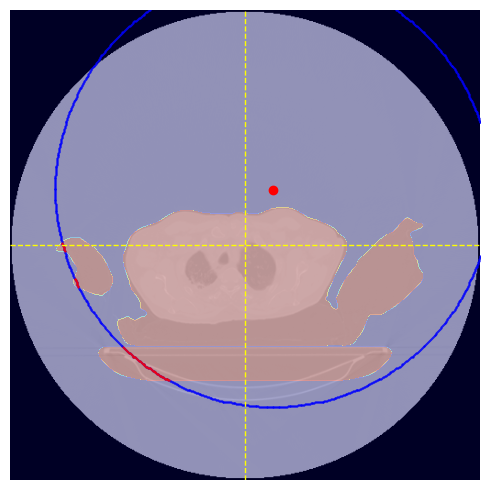

Collision angle ranges (in degrees): [(195.3, 269.7)]


In [19]:
slice_z_mm = 150

# Step 1: Load DICOM metadata, including pixel spacing, slice thickness, image shape and image origin from ImagePositionPatient

pixel_spacing, slice_thickness, image_shape, image_origin_mm = extract_dicom_metadata(folder_path)
ct_images, slice_thicknesses = load_ct_images_from_folder(folder_path)

# Step 3: Extract contours of interest (e.g., couch, body, immobilizer) from RS file
structure_keywords = ['body', 'immobilizer', 'couch', 'mask', 'arm']
structure_contours = extract_structures(rs_file_path, structure_keywords)

# Step 4: Compute centroids of each structure to understand their positions in absolute coordinates
centroids = compute_centroids(structure_contours)
print("Computed centroids:", centroids)

# Step 5: Define the circle properties for collision detection
circle_center_mm = isocenter_position(image_origin_mm, image_shape, pixel_spacing, delta_x, delta_y)

# Step 6: Generate a mask for a specific CT slice (e.g., z=49 mm)
closest_index = min(range(len(slice_thicknesses)), key=lambda i: abs(slice_thicknesses[i] - slice_z_mm))
image = ct_images[closest_index]
mask = contours_to_mask_2d(image_shape, structure_contours, pixel_spacing, 
                           slice_z_mm=slice_z_mm, image_origin_mm=image_origin_mm)

# Step 7: Visualize the image, mask, and trajectory of the gantry:
semi_axes_mm=compute_semi_axes(angle_deg=couch_angle, radius_mm=circle_radius_mm)
debug_draw_alignment(image=image, mask=mask, center_mm=circle_center_mm, 
                      semi_axes_mm=semi_axes_mm, couch_angle=couch_angle, pixel_spacing=pixel_spacing, 
                      image_origin_mm=image_origin_mm)

#Step 8: Computing the gantry's trajectory angle for which the collision happens:
collision_ranges = extract_collision_angles(mask=mask, center_mm=circle_center_mm,
                                            semi_axes_mm=semi_axes_mm,couch_angle=couch_angle,
                                            pixel_spacing=pixel_spacing, image_origin_mm=image_origin_mm,
                                            collimator_diameter=collimator_diameter, gantry_radius=circle_radius_mm,
                                            angle_step=1)
print("Collision angle ranges (in degrees):", collision_ranges)



Multiple image test (every 1cm)

Structure 'CouchSurface' found!
Structure 'CouchInterior' found!
Contours detected for CouchSurface at Z = 110.0 mm
Contours detected for CouchSurface at Z = 110.0 mm
Contours detected for CouchInterior at Z = 110.0 mm
Structure 'BODY' found!
Skipping slice Z: -58.0
Skipping slice Z: -57.0
Skipping slice Z: -56.0
Skipping slice Z: -54.0
Skipping slice Z: -53.0
Skipping slice Z: -52.0
Skipping slice Z: -51.0
Skipping slice Z: -50.0
Skipping slice Z: -49.0
Skipping slice Z: -48.0
Skipping slice Z: -47.0
Skipping slice Z: -46.0
Skipping slice Z: -44.0
Skipping slice Z: -43.0
Skipping slice Z: -42.0
Skipping slice Z: -41.0
Skipping slice Z: -40.0
Skipping slice Z: -39.0
Skipping slice Z: -38.0
Skipping slice Z: -37.0
Skipping slice Z: -36.0
Skipping slice Z: -34.0
Skipping slice Z: -33.0
Skipping slice Z: -32.0
Skipping slice Z: -31.0
Skipping slice Z: -30.0
Skipping slice Z: -29.0
Skipping slice Z: -28.0
Skipping slice Z: -27.0
Skipping slice Z: -26.0
Skipping slice Z: -24.0
Skipping slic

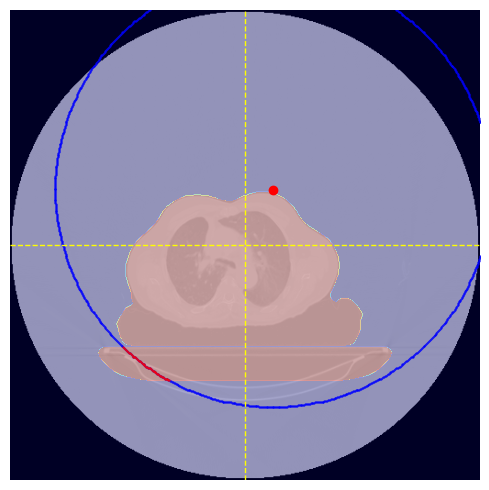

Collision angle ranges (in degrees): [(195.3, 238.7)]
Skipping slice Z: 96.0
Skipping slice Z: 97.0
Skipping slice Z: 98.0
Skipping slice Z: 99.0
Skipping slice Z: 100.0
Skipping slice Z: 101.0
Skipping slice Z: 102.0
Skipping slice Z: 103.0
Skipping slice Z: 104.0
Processing slice Z: 105.0
Contours detected for BODY at Z = 105.0 mm
Contours detected for BODY at Z = 105.0 mm


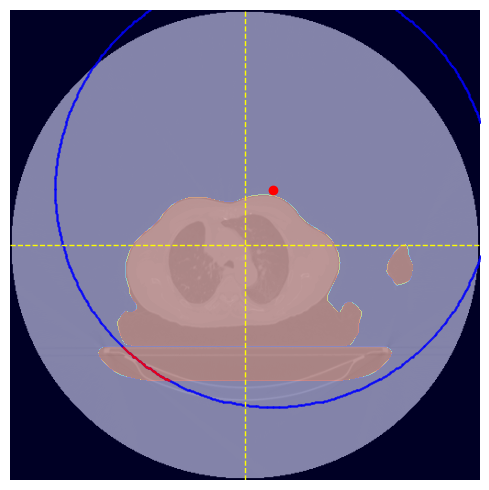

Collision angle ranges (in degrees): [(195.3, 238.7)]
Skipping slice Z: 106.0
Skipping slice Z: 107.0
Skipping slice Z: 108.0
Skipping slice Z: 109.0
Skipping slice Z: 110.0
Skipping slice Z: 111.0
Skipping slice Z: 112.0
Skipping slice Z: 113.0
Skipping slice Z: 114.0
Processing slice Z: 115.0
Contours detected for BODY at Z = 115.0 mm
Contours detected for BODY at Z = 115.0 mm


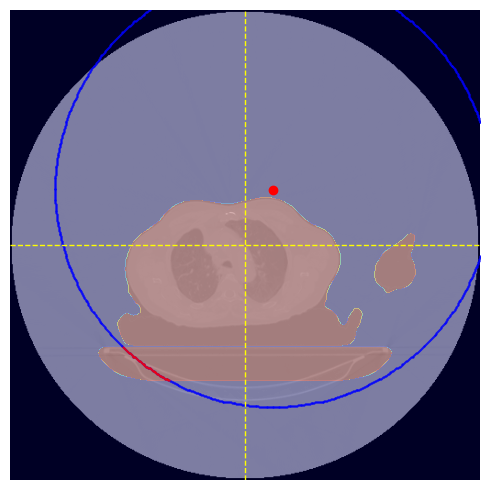

Collision angle ranges (in degrees): [(195.3, 238.7)]
Skipping slice Z: 116.0
Skipping slice Z: 117.0
Skipping slice Z: 118.0
Skipping slice Z: 119.0
Skipping slice Z: 120.0
Skipping slice Z: 121.0
Skipping slice Z: 122.0
Skipping slice Z: 123.0
Skipping slice Z: 124.0
Processing slice Z: 125.0
Contours detected for BODY at Z = 125.0 mm
Contours detected for BODY at Z = 125.0 mm


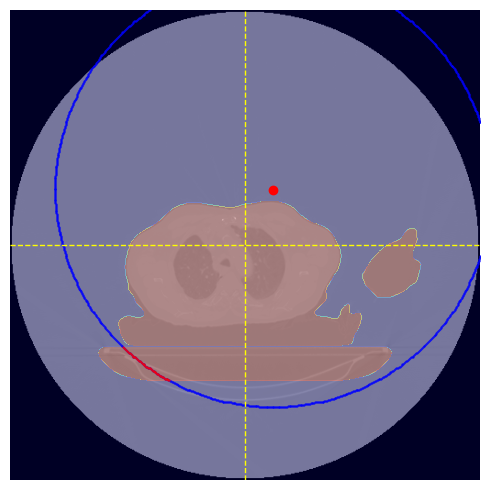

Collision angle ranges (in degrees): [(195.3, 238.7)]
Skipping slice Z: 126.0
Skipping slice Z: 127.0
Skipping slice Z: 128.0
Skipping slice Z: 129.0
Skipping slice Z: 130.0
Skipping slice Z: 131.0
Skipping slice Z: 132.0
Skipping slice Z: 133.0
Skipping slice Z: 134.0
Skipping slice Z: 136.0
Skipping slice Z: 137.0
Skipping slice Z: 138.0
Skipping slice Z: 139.0
Skipping slice Z: 140.0
Skipping slice Z: 141.0
Skipping slice Z: 142.0
Skipping slice Z: 143.0
Skipping slice Z: 144.0
Skipping slice Z: 146.0
Skipping slice Z: 147.0
Skipping slice Z: 148.0
Skipping slice Z: 149.0
Skipping slice Z: 150.0
Skipping slice Z: 151.0
Skipping slice Z: 152.0
Skipping slice Z: 153.0
Skipping slice Z: 154.0
Skipping slice Z: 156.0
Skipping slice Z: 157.0
Skipping slice Z: 158.0
Skipping slice Z: 159.0
Skipping slice Z: 160.0
Skipping slice Z: 161.0
Skipping slice Z: 162.0
Skipping slice Z: 163.0
Skipping slice Z: 164.0
Skipping slice Z: 166.0
Skipping slice Z: 167.0
Skipping slice Z: 168.0
Skipping s

In [15]:

# Step 1: Extracting the DICOM metadata of the first image in the folder
pixel_spacing, slice_thickness, image_shape, image_origin_mm = extract_dicom_metadata(folder_path)

# Step 2: Loading all the images and slice thicknesses, ordered by the Slice_thickness DICOM tag
ct_images, slice_thicknesses = load_ct_images_from_folder(folder_path)

# Step 3: Defining the isocenter position for the patient and the configuration of the gantry's trajectory
circle_center_mm = isocenter_position(image_origin_mm, image_shape, pixel_spacing, delta_x, delta_y)
semi_axes_mm = compute_semi_axes(angle_deg=couch_angle, radius_mm=circle_radius_mm)

# Step 4: Compute the couch mask (only once, as it is the same for all slices)
couch_structure_keywords = ["couch"]
couch_structure_contours = extract_structures(rs_file_path, couch_structure_keywords)
z_mid = (z_min + z_max) / 2
available_indices = list(range(len(slice_thicknesses)))
if available_indices:
    closest_index = min(available_indices, key=lambda i: abs(slice_thicknesses[i] - z_mid))
else:
    closest_index = np.random.choice(available_indices)
    print(f"Closest index based on z_mid not found. Using random index {closest_index}.")

couch_mask = contours_to_mask_2d(
    image_shape, couch_structure_contours, pixel_spacing, 
    slice_z_mm=slice_thicknesses[closest_index], image_origin_mm=image_origin_mm
)

# Step 5: Perform per-slice analysis for body structures
body_structure_keywords = ["body"]
body_structure_contours = extract_structures(rs_file_path, body_structure_keywords)

for image, slice_z_mm in zip(ct_images, slice_thicknesses):
    if (slice_z_mm - z_min) % spacing == 0:
        if z_min <= slice_z_mm <= z_max:
            print(f"Processing slice Z: {slice_z_mm}")

            # Compute the body mask for the current slice
            body_mask = contours_to_mask_2d(
                image_shape, body_structure_contours, pixel_spacing, 
                slice_z_mm=slice_z_mm, image_origin_mm=image_origin_mm
            )
            
            # Combine the couch mask with the body mask
            combined_mask = np.logical_or(body_mask, couch_mask)

            # Plot and analyze
            debug_draw_alignment(
                image=image, mask=combined_mask, center_mm=circle_center_mm, 
                semi_axes_mm=semi_axes_mm, couch_angle=couch_angle, pixel_spacing=pixel_spacing, 
                image_origin_mm=image_origin_mm
            )
            
            # Extract collision angles
            collision_ranges = extract_collision_angles(
                mask=combined_mask, center_mm=circle_center_mm, semi_axes_mm=semi_axes_mm,
                couch_angle=couch_angle, pixel_spacing=pixel_spacing, image_origin_mm=image_origin_mm,
                collimator_diameter=collimator_diameter, gantry_radius=circle_radius_mm,
                angle_step=1
            )
            print("Collision angle ranges (in degrees):", collision_ranges)
    else:
        print(f"Skipping slice Z: {slice_z_mm}")


One image test (sum of the masks every 1 cm to search for potential collisions)

Structure 'CouchSurface' found!
Structure 'CouchInterior' found!
Contours detected for CouchSurface at Z = 110.0 mm
Contours detected for CouchSurface at Z = 110.0 mm
Contours detected for CouchInterior at Z = 110.0 mm
Structure 'BODY' found!
Contours detected for BODY at Z = 95.0 mm
Contours detected for BODY at Z = 105.0 mm
Contours detected for BODY at Z = 105.0 mm
Contours detected for BODY at Z = 115.0 mm
Contours detected for BODY at Z = 115.0 mm
Contours detected for BODY at Z = 125.0 mm
Contours detected for BODY at Z = 125.0 mm


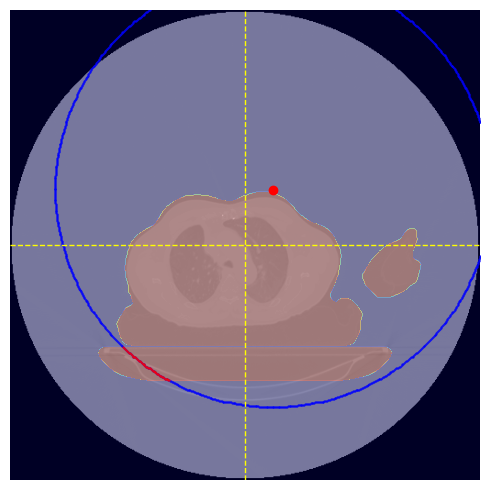

Collision angle ranges (in degrees): [(195.3, 269.7)]
Slices analized: 4


In [16]:
# Step 1: Extracting the Dicom metadata of the first image in the folder
pixel_spacing, slice_thickness, image_shape, image_origin_mm = extract_dicom_metadata(folder_path)

# Step 2: Loading of all the images, slice thiknesses ordered by Slice_thickness dicomtag and returns in a list of those two elements
ct_images, slice_thicknesses = load_ct_images_from_folder(folder_path)

# Step 3: Defining the isocenter position for the patient and the configuraation of the gantry's trajectory:
circle_center_mm = isocenter_position(image_origin_mm, image_shape, pixel_spacing, delta_x, delta_y)
semi_axes_mm=compute_semi_axes(angle_deg=couch_angle, radius_mm=circle_radius_mm)

# Step 4: Initializing a unified mask with the same shape as the CT image (all zeros)
unified_mask = np.zeros(image_shape, dtype=bool)

# Step 5: Computing the couch mask identical for all images
# Step 5: Computing the couch mask identical for all images
structure_keywords = ["couch"]
structure_contours = extract_structures(rs_file_path, structure_keywords)
centroids = compute_centroids(structure_contours)
z_mid = (z_min + z_max) / 2

# Check for valid Z-levels and choose the closest or fallback index
available_indices = list(range(len(slice_thicknesses)))
if available_indices:
    closest_index = min(available_indices, key=lambda i: abs(slice_thicknesses[i] - z_mid))
else:
    # Fallback to a random valid index if no valid indices are available
    closest_index = np.random.choice(available_indices)
    print(f"Closest index based on z_mid not found. Using random index {closest_index}.")

# Generate the couch mask
couch_mask = contours_to_mask_2d(
    image_shape, structure_contours, pixel_spacing, 
    slice_z_mm=slice_thicknesses[closest_index],  # Use selected slice thickness
    image_origin_mm=image_origin_mm
)

# Combine the couch mask with the unified mask
unified_mask = np.logical_or(unified_mask, couch_mask)

# Step 6: Computing masks for body dependant of slice thickness and concrete image.
count = 0
structure_keywords = ["body"]
structure_contours = extract_structures(rs_file_path, structure_keywords)
centroids = compute_centroids(structure_contours)
# Loop through images and Z-coordinates with a 10 mm step to add body structure
for image, slice_z_mm in zip(ct_images, slice_thicknesses):
    # Check if the slice_z_mm aligns with a 10 mm interval
    if (slice_z_mm - z_min) % spacing == 0:
        if z_min <= slice_z_mm <= z_max:
            body_mask = contours_to_mask_2d(
                    image_shape, structure_contours, pixel_spacing, 
                    slice_z_mm=slice_z_mm, image_origin_mm=image_origin_mm
                    )
                
            # Combine the body mask with the unified mask
            unified_mask = np.logical_or(unified_mask, body_mask)
            count = count + 1
# Step 7: selecting the image for z between z_min and z_max for plotting
image = ct_images[closest_index]
slice_z_mm = slice_thicknesses[closest_index]

# Step 8:  Plotting of the trajectory and collision prediction.
debug_draw_alignment(
    image=image,  
    mask=unified_mask, 
    center_mm=circle_center_mm, 
    semi_axes_mm=semi_axes_mm, 
    couch_angle=couch_angle, 
    pixel_spacing=pixel_spacing, 
    image_origin_mm=image_origin_mm
)

#Step 9: Computing the gantry's trajectory angle for which the collision happens:
collision_ranges = extract_collision_angles(mask=mask, center_mm=circle_center_mm,
                                            semi_axes_mm=semi_axes_mm,couch_angle=couch_angle,
                                            pixel_spacing=pixel_spacing, image_origin_mm=image_origin_mm,
                                            collimator_diameter=collimator_diameter, gantry_radius=circle_radius_mm,
                                            angle_step=1)
print("Collision angle ranges (in degrees):", collision_ranges)
print("Slices analized:", count)